## Loading partitioning on sentiment 

OBS alt kode herunder er et udklip med små ændringer fra Mads's kode, så denne fil kan også køres efter "sentiment.ipynb"

In [36]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
from sklearn.cluster import KMeans
import numpy as np
import json

# Load Graph
G_path = Path("artist_network_with_embeddings.graphml")
G = nx.read_graphml(str(G_path)) 

In [48]:
# print example of node with all attributes and keys
example_node = list(G.nodes(data=True))[0]
print("Example node attributes:", example_node)
print(example_node[1].keys())  # print attribute keys

Example node attributes: ('Missy_Elliott', {'songs': '["Lose Control (feat. Ciara & Fat Man Scoop)", "Work It", "Gossip Folks (feat. Ludacris)", "One Minute Man (feat. Ludacris)", "Get Ur Freak On", "Pep Rally", "WTF (Where They From) [feat. Pharrell Williams]"]', 'albums': '["Under Construction", "Miss E...So Addictive", "Pep Rally", "The Cookbook", "WTF (Where They From) [feat. Pharrell Williams]"]', 'playlists': '[0, 203, 779, 112, 912, 218, 127]', 'num_playlists': 7, 'num_songs': 7, 'avg_song_duration': 236137.08333333334, 'lyrics': '\n\nIs it worth it? Let me work it\nI put my thing down, flip it and reverse it\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\nIf you got a big— let me search ya\nAnd find out how hard I gotta work ya\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP (C\'mon)\n\nI\'d like to get to know ya so I could show ya\nPut the pussy on ya like I told ya\nGive me a

In [ ]:
# --- 2. PREPARE VECTORS ---
node_ids = []
vectors = []

for node in G.nodes():
    # 1. Get the string attribute
    vec_str = G.nodes[node].get('lyric_vector')
    
    if vec_str:
        try:
            # 2. Convert JSON string back to Numpy Array
            vec = np.array(json.loads(vec_str))
            vectors.append(vec)
            node_ids.append(node)
        except:
            pass # Skip nodes with corrupted data

X = np.array(vectors)

# To get the number of partitions from the structural analysis (Louvain)
louvain_communities = list(nx.community.louvain_communities(G, seed=42))
num_comm = len(louvain_communities)

# This groups artists purely by how similar their lyrics are (Cosine distance logic)
kmeans = KMeans(n_clusters=num_comm, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Create the partition dictionary: {node_id: cluster_id}
lyric_partition = {node: int(label) for node, label in zip(node_ids, labels)}


Extracting embedding vectors from nodes...


OBS her stopper MADS's kode igen ;)

In [51]:
# calculate mean value of sentiment of each label, using all nodes within the label
cluster_sentiments = {}
cluster_sizes = {}

for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment_compound')
    cluster_id = lyric_partition.get(node)
    if sentiment is not None and cluster_id is not None:
        cluster_sentiments.setdefault(cluster_id, 0)
        cluster_sizes.setdefault(cluster_id, 0)
        cluster_sentiments[cluster_id] += float(sentiment)
        cluster_sizes[cluster_id] += 1
# Calculate average sentiment for each cluster
for cid in cluster_sentiments:
    cluster_sentiments[cid] /= cluster_sizes[cid]

# print with lowest sentiment first
for cid, avg_sentiment in sorted(cluster_sentiments.items(), key=lambda x: x[1]):
    print(f"Cluster {cid}: Average Sentiment = {avg_sentiment:.4f}")

Cluster 9: Average Sentiment = -0.2573
Cluster 6: Average Sentiment = -0.2364
Cluster 0: Average Sentiment = 0.3910
Cluster 4: Average Sentiment = 0.3968
Cluster 8: Average Sentiment = 0.4626
Cluster 2: Average Sentiment = 0.5271
Cluster 5: Average Sentiment = 0.6087
Cluster 1: Average Sentiment = 0.6272
Cluster 7: Average Sentiment = 0.6585
Cluster 3: Average Sentiment = 0.7140


We expect cluster 9 to have more sad words, cluster 0 to be more average or without sentiment, and cluster 3 to be more happy.

In the following we create TF lists and IDF word counts of the tokens/words of the sentiment partitioned artists. 

- We have filtered out words that appear less than 5 times, and all punctuation. 
- We have also made all characters lower case. 
- We also remove some stop words
- We normalize TF by the total tokens per partition.

In [21]:
# Compute IDF
def compute_idf(df, N, method="smooth"):
    if method == "standard":
        return math.log10(N / df)
    elif method == "smooth":
        return math.log10(N / (1 + df)) + 1
    elif method == "prob":
        return math.log10((N - df) / df)

In [23]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
# Creating TF-IDF analysis

lemmatizer = WordNetLemmatizer()
stopwords = set(ENGLISH_STOP_WORDS)

# remove sound words like 'oh', 'la', 'na', 'yeah', 'ooh'
sound_words = {'oh', 'la', 'na', 'yeah', 'ooh', 'uh', 'ta', 'ah', 'hoo', 'ha', 'mm', 
               'hmm', 'da', 'wo', 'woah', 'whoa', 'hey', 'ay', 'ayyy', 'woo', 'woohoo',
               'ra-ta-ta-ta-ta-ta-ta-ta-ta-ta', 'dum', 'dum-dum', 'la-la-la', 'na-na-na', 'laa', 'laaa',
               'naaa', 'naaaa', 'yeaaah', 'yeaah', 'yeaaaah', 'ooh-ooh', 'uh-huh', 'mm-hmm',
               'ba-bum-bum-bum-bum', 'bom', 'bom-bom', 'da-da-da', 'da-da', 'duh', 'duh-duh', 'la-la',
               'na-na', 'na-na-na-na', 'whoa-oh', 'whoa-oh-oh', 'woo-woo', 'woo-woo-woo', 'yah', 'yahh',
               'ba-bum-bum-bum-bum', 'ba-bum-bum-bum-bum-bum', 'oh-oh', 'oh-oh-oh', 'uh-oh', 'uh-oh-oh','ooh-ooh-ooh',
               'woo-hoo','m-m-m-m-m', 'oh-nah-nah-nah','mmm-mm-hmm-mm', 'mm-mm-hmm', 'hmmm-mm'}
uninteresting_words = {"i'm", "im", "ive", "i've", "youre", "you're", "hes", "he's", "it's", "its",
                       "shes", "she's", "thats", "that's", "whats", "what's", "couldnt", "i'll", "ill", "youll", "you'll",
                       "he'll", "she'll", "we'll", "well", "they'll", "theyll", "isnt", "isn't", "wasnt", "wasn't",
                       "werent", "weren't", "dont", "don't", "doesnt", "doesn't", "wont", "won't", "let's", "lets",
                       "shouldnt", "shouldn't", "mightnt", "mightn't", "mustnt", "mustn't", "hadnt", "hadn't","let",
                       "couldn't", "wouldnt", "wouldn't", "didnt", "didn't", "got", "gonna","there's"}
stopwords.update(sound_words)
stopwords.update(uninteresting_words)


In [ ]:
# BUILD TF and TF-IDF per LYRIC CLUSTER
import re
from collections import Counter, defaultdict

# Parameters
min_word_count = 5   # filter words that occur less than this across a cluster
top_k_per_cluster = 200

# Build TF lists aggregated by lyrical cluster (lyric_partition: {node: cluster_id})
cluster_counts = defaultdict(Counter) # this will be {cluster_id: Counter({word: count, ...}), ...}
cluster_token_totals = defaultdict(int) # total tokens per cluster

for node, data in G.nodes(data=True):
    if node not in lyric_partition:
        continue
    lyrics = str(data.get('lyrics', ''))
    if len(lyrics) < 50: # making sure that we can display at least 50 words for an artist
        continue

    # tokenize + normalize + lemmatize
    lyrics = lyrics.replace("’", "'").lower()
    tokens = re.findall(r"\b[a-z']{2,}\b", lyrics)          # alphabetic tokens, len>=2
    lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]

    # update cluster counters
    cid = int(lyric_partition[node])
    cluster_counts[cid].update(lemmas)
    cluster_token_totals[cid] += len(lemmas)

# Filter infrequent words within each cluster and compute IDF across clusters
cluster_TF = {} # {cluster_id: Counter({word: count, ...}), ...}
IDF_counts_cluster = Counter()
for cid, counter in cluster_counts.items():
    # keep only words that occur at least `min_word_count` in this cluster
    filtered = Counter({w: c for w, c in counter.items() if c >= min_word_count})
    cluster_TF[cid] = filtered
    # update document frequency (word appears in this cluster)
    for w in filtered:
        IDF_counts_cluster[w] += 1

num_cluster_docs = len(cluster_TF)

# Compute TF-IDF per cluster
cluster_TFIDF = {}
for cid, counter in cluster_TF.items():
    total = sum(counter.values()) or 1
    tfidf = {}
    for w, cnt in counter.items():
        tf = cnt / total
        df = IDF_counts_cluster.get(w, 0)
        idf = compute_idf(df, num_cluster_docs, method="smooth")   # uses compute_idf from notebook
        tfidf[w] = tf * idf
    # sort by tfidf desc
    cluster_TFIDF[cid] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:top_k_per_cluster]

# Save results in dicts
TF_lists_by_cluster = {cid: list(counter.items()) for cid, counter in cluster_TF.items()}
TFIDF_lists_by_cluster = cluster_TFIDF

Built TF lists for 10 lyric clusters (min_count=5).
Example top terms for cluster 0: [('like', 0.021984392014345825), ('know', 0.014385791908649222), ('just', 0.012085210720869221), ('love', 0.011483813978835444), ("ain't", 0.008343186548214612), ('say', 0.007989985287020171), ('cause', 0.007732243826148553), ('nigga', 0.007589054125664321), ('time', 0.007331312664792702), ('make', 0.006825375723081748)]


We can now visualize the difference between the TF and TF-IDF in wordclouds. We have chosen to display the top 50 words to make it possible to distinguish between the words but still get a large representation. 

In [55]:
from wordcloud import WordCloud

def plot_tf_vs_tfidf(TF_lists_by_cluster, TFIDF_lists_by_cluster, clusters=None, NUM_WORDS=50, n=6,
                     tf_title="TF (raw counts)", tfidf_title="TF-IDF (top terms)",
                     wc_kwargs=None, figsize_per_row=(12,3),
                     plot_tf=True, plot_tfidf=True):
    """
    Plot TF vs TF-IDF wordclouds for clusters.
      - TF_lists_by_cluster: {cid: [(word,count), ...], ...}
      - TFIDF_lists_by_cluster: {cid: [(word,score), ...], ...}
      - clusters: optional list of cluster ids to plot (ordered). If None, choose top-n by TF size.
      - n: number of clusters to plot
      - plot_tf / plot_tfidf: booleans to control which column(s) to draw
    """
    wc_kwargs = wc_kwargs or {"background_color":"white", "width":600, "height":400}
    # choose clusters if not provided
    if clusters is None:
        # rank clusters by total TF tokens (fallback to len of TF list)
        ranking = sorted(TF_lists_by_cluster.keys(),
                         key=lambda c: sum(count for _, count in TF_lists_by_cluster.get(c, [])),
                         reverse=True)
        clusters = ranking[:n]
    else:
        clusters = list(clusters)[:n]

    rows = len(clusters)
    cols = int(bool(plot_tf)) + int(bool(plot_tfidf))

    if rows == 0 or cols == 0:
        print("No clusters or no plot columns selected.")
        return

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_row[0], figsize_per_row[1]*rows))
    # normalize axes to 2D array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes]).reshape(1, cols)
    elif cols == 1:
        axes = np.array(axes).reshape(rows, 1)

    for i, cid in enumerate(clusters):
        col_idx = 0
        # TF frequencies dict
        tf_pairs = TF_lists_by_cluster.get(cid, [])
        tf_freq = {w: c for w, c in tf_pairs}
        # TF-IDF dict (use scores directly)
        tfidf_pairs = TFIDF_lists_by_cluster.get(cid, [])
        tfidf_freq = {w: score for w, score in tfidf_pairs}

        if plot_tf:
            ax = axes[i, col_idx]
            if tf_freq:
                wc_tf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(tf_freq)
                ax.imshow(wc_tf, interpolation='bilinear')
                ax.set_title(f"Cluster {cid} — {tf_title}")
            else:
                ax.text(0.5,0.5,"No TF data", ha='center', va='center')
            ax.axis('off')
            col_idx += 1

        if plot_tfidf:
            ax = axes[i, col_idx]
            if tfidf_freq:
                max_score = max(tfidf_freq.values()) or 1.0
                scaled = {w: (s/max_score) for w,s in tfidf_freq.items()}
                wc_tfidf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(scaled)
                ax.imshow(wc_tfidf, interpolation='bilinear')
                ax.set_title(f"Cluster {cid} — {tfidf_title}")
            else:
                ax.text(0.5,0.5,"No TF-IDF data", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

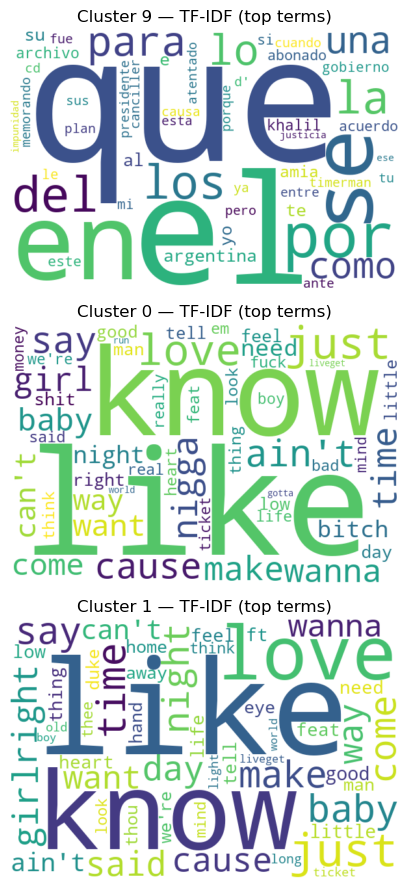

In [56]:
# plot cluster 9, 0 and 1
plot_tf_vs_tfidf(TF_lists_by_cluster, TFIDF_lists_by_cluster, NUM_WORDS=50, clusters=[9,0,1],plot_tf=False, plot_tfidf=True)

In [57]:
# plot list of all artists in cluster 9, 0 and 1
for cid in [9,0,1]:
    artists_in_cluster = [node for node, c in lyric_partition.items() if c == cid]
    print(f"Cluster {cid} artists ({len(artists_in_cluster)}):")
    for artist in artists_in_cluster:
        print(f" - {artist}")

Cluster 9 artists (37):
 - Selena
 - Shakira
 - Sonora_Carruseles
 - Sebastian_Yatra
 - Ozuna
 - Romeo_Santos
 - Deorro
 - Nach
 - Yandel
 - Reik
 - Voz_De_Mando
 - Don_Omar
 - J_Balvin
 - Luis_Fonsi
 - Skrillex
 - Karol_G
 - Lary_Over
 - Maluma
 - Noriel
 - Pepe_Quintana
 - Juanes
 - Daddy_Yankee
 - Farruko
 - Charly_Black
 - Heroes_Del_Silencio
 - Grupo_Niche
 - Cosculluela
 - Alfredo_Olivas
 - Alta_Consigna
 - Ariel_Camacho_y_Los_Plebes_Del_Rancho
 - El_Fantasma
 - Los_Plebes_del_Rancho_de_Ariel_Camacho
 - Virlan_Garcia
 - Bad_Bunny
 - Bryant_Myers
 - Alexis_y_Fido
 - Gilberto_Santa_Rosa
Cluster 0 artists (87):
 - Ne-Yo
 - The_National
 - Demi_Lovato
 - Jonas_Brothers
 - Jennifer_Lopez
 - Machine_Gun_Kelly
 - Kevin_Abstract
 - Caribou
 - Hannah_Montana
 - Travie_McCoy
 - Mary_Wells
 - Pharrell_Williams
 - The_Beatles
 - Wale
 - The_White_Stripes
 - Rick_James
 - The_Kinks
 - The_Offspring
 - JoJo
 - Travis_Scott
 - Jimmy_Eat_World
 - Wiz_Khalifa
 - Thomas_Rhett
 - Marina_and_the_Dia

In [ ]:
# combine TF-IDF score for all clusters with negative sentiment score
combined_cluster_data = []
for cid in TFIDF_lists_by_cluster.keys():
    tfidf_list = TFIDF_lists_by_cluster[cid]
    avg_sentiment = cluster_sentiments.get(cid, 0.0)
    combined_cluster_data.append({
        'cluster_id': cid,
        'avg_sentiment': avg_sentiment,
        'tfidf_terms': tfidf_list
    })

# Sort clusters by average sentiment (ascending)
combined_cluster_data.sort(key=lambda x: x['avg_sentiment'])